In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
from copy import deepcopy
from weighted_levenshtein import lev
import time

from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import streaming_classifier, zeroes_classifier


In [2]:
waves, labels, samprate = load_training_data(path = "Datasets/",
                                             scale_factor= 1,
                                             blacklist = ['data0'],
                                             whitelist = ["data"])


samprate = 10000


time_buffers = {"data3":(-0.3, 0.55),
                "data2":(-0.3, 0.55),
                "data0":(-0.3, 0.55),
                "data1":(-0.3, 0.55),
                "data5":(-0.5, 0.75),
                "data4":(-0.5, 0.75)}


dict_keys(['data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7', 'data8']) dict_keys(['data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7', 'data8'])
c:\Users\darap\Documents\School\University\2021, Sem. 1\DATA3888\Aqua10\Classifier\load_data.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


In [3]:
def my_lev_dist(prediction, actual, L_cost = 1.25, R_cost = 1.25, under_score_cost = 0.5):
    substitute_costs = np.ones((128, 128), dtype=np.float64)  
    substitute_costs[ord('L'), ord('R')] = L_cost
    substitute_costs[ord('R'), ord('L')] = R_cost
    substitute_costs[ord('_'), ord('L')] = under_score_cost
    substitute_costs[ord('_'), ord('R')] = under_score_cost
    return lev(prediction, actual, substitute_costs = substitute_costs)



def ts_zero_crossings(x):
    return np.sum(x[0:-1]*x[1::] <= 0)


In [4]:
# ASSUMES THAT HEIGHT_THRESHOLD AND CONSECUTIVE_SAMPLES_THRESHOLD ARE INDEPENDENT

# Set parameters such that event detection window lands in the middle of the signal

det_window = 0.35
hyp_event_smart_threshold_factor = 0.31

hyp_event_smart_threshold_window = 5

window_size = 0.66
hyp_detection_buffer_end = (window_size - det_window) / 2
hyp_detection_buffer_start = (window_size - det_window) / 2

N_loops_over_window = int(np.ceil(window_size/0.05))


# hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))
# print(hyp_consecutive_triggers)




# fig, ax = plt.subplots(len(waves), 1)
# fig.set_size_inches(15, 3*len(waves))



classifiers = {"Zeros classifier": zeroes_classifier}

all_accuracies = {}

for classifier_label, classifier in classifiers.items():
    print(classifier_label)
    for w in np.linspace(0.001, 0.5, 100):
        print(w)
        consec_threshold = w

#         hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))


        current_accuracies = []
        for i, key in enumerate(waves):
            
            predictions, predictions_timestamps, predictions_storage = streaming_classifier(
                waves[key],
                samprate,
                classifier = classifier,
                window_size = window_size, # time plotted in window [s]
                N_loops_over_window = N_loops_over_window, # implicitly defines buffer to be 1/x of the window
                total_time = None,  # max time
                hyp_detection_buffer_end = hyp_detection_buffer_end, # seconds - how much time to shave off either end of the window in order to define the middle portion
                hyp_detection_buffer_start = hyp_detection_buffer_start,
                hyp_event_smart_threshold_window = hyp_event_smart_threshold_window, 
                hyp_event_smart_threshold_factor = hyp_event_smart_threshold_factor, 
                hyp_calibration_statistic_function = lambda x: ts_zero_crossings(x)/(len(x)/samprate)*det_window, # Function that calculates the calibration statistic
                hyp_test_statistic_function = ts_zero_crossings, # Function that calculates the test statistic
                hyp_event_history = 30,
    #             hyp_timeout = 20,
                hyp_consecutive_triggers = 2,
                hyp_consecutive_reset = 10,
                zeroes_consec_threshold = w,
                zeroes_height_threshold = 20,
                using_zeroes_classifier = True,
                plot = False,
                store_events = True, 
                verbose=False,
                live = False,
    #             dumb_threshold = True,
                flip_threshold = True
    #             timeout = True
            )

            actuals = "".join(labels[key].label)

            lev_dist = my_lev_dist(predictions, actuals)
            acc = max((len(actuals) - lev_dist), 0)/len(actuals)
            current_accuracies.append(acc)
        if consec_threshold in all_accuracies:
            all_accuracies[consec_threshold] += current_accuracies
        else:
            all_accuracies[consec_threshold] = current_accuracies

print("done")

Zeros classifier
0.001
0.0060404040404040404
0.01108080808080808
0.016121212121212123
0.021161616161616163
0.026202020202020202
0.031242424242424245
0.036282828282828285
0.041323232323232324
0.046363636363636364
0.0514040404040404
0.05644444444444444
0.06148484848484849
0.06652525252525253
0.07156565656565657
0.07660606060606061
0.08164646464646465
0.08668686868686869
0.09172727272727273
0.09676767676767677
0.1018080808080808
0.10684848484848485
0.11188888888888888
0.11692929292929292
0.12196969696969698
0.12701010101010102
0.13205050505050506
0.1370909090909091
0.14213131313131314
0.14717171717171718
0.15221212121212122
0.15725252525252525
0.1622929292929293
0.16733333333333333
0.17237373737373737
0.1774141414141414
0.18245454545454545
0.1874949494949495
0.19253535353535353
0.19757575757575757
0.2026161616161616
0.20765656565656565
0.2126969696969697
0.21773737373737373
0.22277777777777777
0.2278181818181818
0.23285858585858585
0.2378989898989899
0.24293939393939395
0.247979797979798


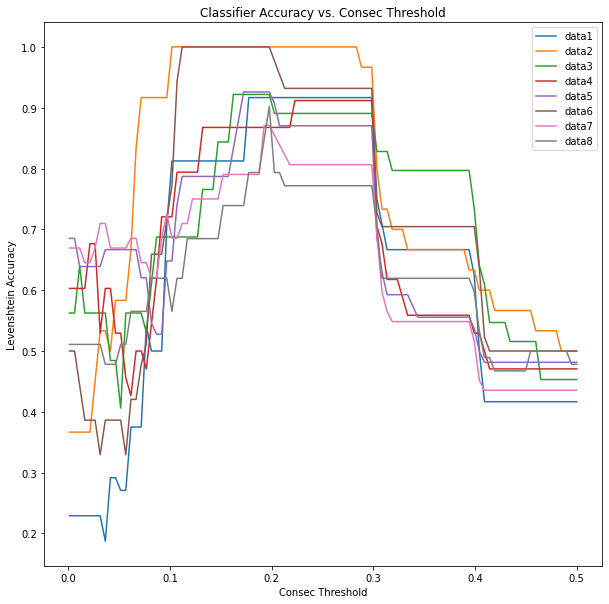

In [6]:
#print(all_accuracies)
plt.figure(figsize=(10, 10))
plt.plot(all_accuracies.keys(), all_accuracies.values())
plt.ylabel("Levenshtein Accuracy")
plt.xlabel("Consec Threshold")
plt.title("Classifier Accuracy vs. Consec Threshold")
plt.legend(waves.keys())

In [20]:
best_consecs = []
best_value = 0
for wav_values in all_accuracies.values():
    for value in wav_values:
        if round(value, 5) > round(best_value, 5):  #need to round because python maintains its floats very imprecisly
            best_value = value

for key, value in all_accuracies.items():
    if round(value, 5) == round(best_value, 5):
        best_consecs.append(key)

print("Best consec threshold values:", best_consecs)
print("Accuracy with best consec threshold:", all_accuracies[best_consecs[0]])

TypeError: type list doesn't define __round__ method